# AN2DL - Apple Elixir

This notebook contains code of a neural network used in a competition. The goal of the competition was to classify plants into two classes (healthy and unhealthy).
The model used in this notebook derived from a well known architecture, ConvNeXt, and uses an advanced augmentation technique called MixUp combined with more traditional augmentation techniques

# Imports and Configs

**Mount the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Imports**

In [1]:
# Deafault Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve

!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz

--2023-11-12 14:02:14--  https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 536546306 (512M) [application/octet-stream]
Saving to: ‘public_data_clean.npz’

public_data_clean.n 100%[===================>] 511.69M  26.0MB/s    in 21s     

2023-11-12 14:02:35 (24.7 MB/s) - ‘public_data_clean.npz’ saved [536546306/536546306]



**Randomnes and Configurations**

In [2]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Defining Functions**

In [3]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()
def plot_confusion_matrix(model, test, test_lbls, figsize, name_jpg):
  # Compute the confusion matrix
  tp = model.predict(test, verbose=0)
  cm = confusion_matrix(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))

  # Compute classification metrics
  accuracy = accuracy_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))
  precision = precision_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  recall = recall_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  f1 = f1_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  lbls = ["Healthy", "Unhealthy"]
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues', xticklabels=lbls, yticklabels=lbls)
  plt.xlabel('Labels', fontsize=6)
  plt.xticks(fontsize=8)
  plt.ylabel('Predicted Labels', fontsize=6)
  plt.yticks(fontsize=8)
  plt.savefig(name_jpg)
  plt.show()
def plot_roc(model, test, test_lbls, figsize, name_jpg):
  # Compute the confusion matrix
  tp = model.predict(test, verbose=0)
  fpr, tpr, threshold = roc_curve(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))

  # Plot the ROC
  plt.figure(figsize=figsize, dpi=200)
  plt.plot([0,1], [0,1], 'y--')
  plt.plot(fpr, tpr, marker='.')
  plt.xlabel('False Positive Rate', fontsize=6)
  plt.ylabel('True Positive Rate', fontsize=6)
  plt.title('ROC Curve')
  plt.savefig(name_jpg)
  plt.show()
def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

# Data Agumentation Functions
def pick_random_label(i, lbls, lbl):
  if lbls[i] == lbl:
    return True
  else:
    return False
def manual_augmentation(imgs, lbls, string_lbls):
  cardinality = pd.DataFrame(string_lbls, columns=['class'])['class'].value_counts()       # Store the Cardinality of the SETS "healthy", "unhealthy"
  ch = cardinality['healthy']
  cu = cardinality['unhealthy']
  diff = ch-cu
  print(cardinality)

  i_arr = []
  ROWS = 2
  COLS = 4
  augm = []
  augm_lbl = []

  if diff > 0:
    print("Augment the Unhealthy with ", diff, "new images")
    for z in range(int(diff/7)):
      index = rnd.randint(0, len(lbls)-1)
      while not pick_random_label(index, string_lbls, "unhealthy") or index in i_arr:
        i_arr.append(index)
        index = rnd.randint(0, len(lbls)-1)

      if string_lbls[index] == "unhealthy":
        i_arr.append(index)
        img = imgs[index]
        for row in range(ROWS):
            for col in range(COLS):
                img = np.rot90(img)
                if row==0 and col==3:
                    continue
                augm.append(img)
                augm_lbl.append(lbls[index])
            if row == 0:
                img = np.flipud(img)
  else:
    print("Augment the Healthy with ", diff, "new images")
    for z in range(int(-diff/7)):
      index = rnd.randint(0, len(lbls)-1)
      while not pick_random_label(index, string_lbls, "unhealthy") or index in i_arr:
        i_arr.append(index)
        index = rnd.randint(0, len(lbls)-1)

      if string_lbls[index] == "unhealthy":
        i_arr.append(index)
        img = imgs[index]
        for row in range(ROWS):
            for col in range(COLS):
                img = np.rot90(img)
                if row==0 and col==3:
                    continue
                augm.append(img)
                augm_lbl.append(lbls[index])
            if row == 0:
                img = np.flipud(img)

  # augm_lbl = list(map(lambda x: 0 if x == "healthy" else 1, augm_lbl))
  # augm_lbl = tfk.utils.to_categorical(augm_lbl, len(np.unique(LBLS)))

  augm = np.array(augm)
  augm_lbl = np.array(augm_lbl)

  imgs = np.concatenate((imgs, augm), axis=0)
  lbls = np.concatenate((lbls, augm_lbl), axis=0)
  print()

  return imgs, lbls
def downsize_augmentation(imgs, lbls, slbls, size):

  ROWS = 2
  COLS = 4
  indices = []
  balance_imgs = []
  balance_lbls = []
  augm_imgs = []
  augm_lbls = []

  cardinality = pd.DataFrame(slbls, columns=['class'])['class'].value_counts()
  ch = cardinality['healthy']
  cu = cardinality['unhealthy']
  diff = ch-cu
  print(cardinality)

  if diff:
    print(f'Downsize Healthy from {ch} to {cu}')
    print()
    for i in range(cu):
      index = rnd.randint(0, len(imgs)-1)
      while pick_random_label(index, slbls, "unhealthy") or index in indices:
        index = rnd.randint(0, len(imgs)-1)

      balance_imgs.append(imgs[index])
      balance_lbls.append(lbls[index])
      indices.append(index)
  else:
    print(f'Downsize Unhealthy from {cu} to {ch}')
    print()


  for i in range(len(slbls)):
    if slbls[i] == "unhealthy":
      balance_imgs.append(imgs[i])
      balance_lbls.append(lbls[i])

  imgs = balance_imgs
  lbls = balance_lbls
  indices = []

  if size > len(imgs):
    size = len(imgs)

  for i in range(size):
    indexh = rnd.randint(0, int(len(lbls)/2)-1)
    while indexh in indices:
      indexh = rnd.randint(0, int(len(lbls)/2)-1)

    img = imgs[indexh]
    lbl = lbls[indexh]
    for row in range(ROWS):
        for col in range(COLS):
            img = np.rot90(img)
            if row==0 and col==3:
                continue
            augm_imgs.append(img)
            augm_lbls.append(lbl)
        if row == 0:
            img = np.flipud(img)
    indices.append(indexh)


    indexu = rnd.randint(int(len(lbls)/2)-1, len(lbls)-1)
    while indexu in indices:
      indexu = rnd.randint(int(len(lbls)/2)-1, len(lbls)-1)

    img = imgs[indexu]
    lbl = lbls[indexu]
    for row in range(ROWS):
        for col in range(COLS):
            img = np.rot90(img)
            if row==0 and col==3:
                continue
            augm_imgs.append(img)
            augm_lbls.append(lbl)
        if row == 0:
            img = np.flipud(img)
    indices.append(indexu)

  imgs = np.array(imgs)
  lbls = np.array(lbls)
  augm_imgs = np.array(augm_imgs)
  lbls_imgs = np.array(augm_lbls)

  imgs = np.concatenate((imgs, augm_imgs), axis=0)
  lbls = np.concatenate((lbls, lbls_imgs), axis=0)

  slbls_ = list(map(lambda x: "unhealthy" if np.argmax(x) else "healthy", lbls))
  print(pd.DataFrame(slbls_, columns=['class'])['class'].value_counts() )
  print()

  return imgs, lbls

def mixup(img_a, img_b, lbl_a, lbl_b, alpha=0.5):
  lmb = rnd.uniform(0.1, 0.25) if rnd.choice([True, False]) else rnd.uniform(0.75, 0.9)

  mixed_img = np.uint8(lmb*img_a + (1-lmb)*img_b)
  mixed_lbl = lmb*lbl_a + (1-lmb)*lbl_b

  return mixed_img, mixed_lbl
def increase_volume_mixup(imgs, lbls, size):
  indices = []
  augm_lbls = []
  augm_imgs = []

  for i in range(size):
    index = rnd.randint(0, len(lbls)-1)
    while index in indices:
      index = rnd.randint(0, len(lbls)-1)
    indices.append([index])

    if np.argmax(lbls[index]):
      index_2 = rnd.randint(0, len(lbls)-1)
      while [index, index_2] in indices or  np.argmax(lbls[index_2]):
        index_2 = rnd.randint(0, len(lbls)-1)
      indices[i].append(index_2)
    elif not np.argmax(lbls[index]):
      index_2 = rnd.randint(0, len(lbls)-1)
      while [index, index_2] in indices or not np.argmax(lbls[index_2]):
        index_2 = rnd.randint(0, len(lbls)-1)
      indices[i].append(index_2)

    aug_img, aug_lbl = mixup(imgs[index], imgs[index_2], lbls[index], lbls[index_2])
    augm_imgs.append(aug_img)
    augm_lbls.append(aug_lbl)


  augm_lbls = np.array(augm_lbls)
  augm_imgs = np.array(augm_imgs)

  imgs = np.concatenate((imgs, augm_imgs), axis=0)
  lbls = np.concatenate((lbls, augm_lbls), axis=0)

  return imgs, lbls

# Test
def test_prediction(model, test, test_lbls):
  tp = model.predict(test, verbose=0)
  tp = np.argmax(tp, axis=-1)
  tgt = np.argmax(test_lbls, axis=-1)
  test_accuracy = accuracy_score(tgt, tp)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

  return tp

# Data Initizialization

**Load the Dataset**

In [4]:
# Initializate
DATA = np.load('public_data_clean.npz', allow_pickle=True)
KEYS = list(DATA.keys())

IMGS = np.array(DATA[KEYS[0]])
LIMG = len(IMGS)
LBLS = np.array(DATA[KEYS[1]])
LBLS_ = np.array(DATA[KEYS[1]])
LLBL = len(LBLS)

BATCH = 32
TEST_PERC = 0.15
VALI_PERC = 0.15

MPLBL = {0: "healthy", 1: "unhealthy"}
RMLBL = {"healthy": 0, "unhealthy": 1}
LBLS = np.array([RMLBL[l] for l in LBLS])
LBLS = tfk.utils.to_categorical(LBLS, len(np.unique(LBLS)))

print('Images: ', LIMG)
print('Labels: ', LLBL)
print()

Images:  4850
Labels:  4850



**Under-Sampling**

In [ ]:
downsize_augmentation(IMGS, LBLS, LBLS_, 1000)
print(len(IMGS))

**Over-Sampling**

In [ ]:
manual_augmentation(IMGS, LBLS, LBLS_)
print(len(IMGS))

**Saving the Dataset**

In [6]:
np.savez_compressed("t003.npz", IMGS, LBLS)

**Plot to check the Data Augmentation**

In [ ]:
plot_images(IMGS[-7:], LBLS[-7:], 0, 1, 7)

**Dataset Classes Cardinality**

In [7]:
LBLS__ = list(map(lambda x: "unhealthy" if x[0]==0. and x[1]==1. else "healthy", LBLS))
print(pd.DataFrame(LBLS__, columns=['class'])['class'].value_counts() )

healthy      3060
unhealthy    3057
Name: class, dtype: int64


**Split Dataset**

In [8]:
# Split the Data Set into Training XT YT, Validation XV YV, Test XTE YTE
Xtrv, XTE, Ytrv, YTE = train_test_split(
    IMGS,
    LBLS,
    test_size=int(TEST_PERC * LIMG),
    **({"random_state":SEED} if not RND else {}),
    stratify=LBLS
)

XT, XV, YT, YV = train_test_split(
    Xtrv,
    Ytrv,
    test_size=int(VALI_PERC*LIMG),
    **({"random_state":SEED} if not RND else {}),
    stratify=Ytrv
)

# Shapes
print('Training Set Shape: ', XT.shape, YT.shape)
print('Validation Set Shape: ', XV.shape, YV.shape)
print('Test Set Shape: ', XTE.shape, YTE.shape)
print()

# Get the Shape of IN OUT
input_shape = XT.shape[1:]
output_shape = YT.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Training Set Shape:  (4663, 96, 96, 3) (4663, 2)
Validation Set Shape:  (727, 96, 96, 3) (727, 2)
Test Set Shape:  (727, 96, 96, 3) (727, 2)

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



**Save the Datasets**

In [9]:
np.savez_compressed("t003_split.npz", Xtrv, XTE, Ytrv, YTE)

**Augmentation Layers**

In [10]:
# Rescaling
data_rescaling = tkl.Rescaling(scale=1./255)                                      # Normalize the Images from 0..255 to 0..1
data_backscaling = tkl.Rescaling(scale=1.*255)                                    # Normalize the Images from 0..1 to 0..255

data_rescaling_c = tkl.Rescaling(scale=1./127.5, offset=-1)                       # Normalize the Images from 0..255 to -1..1
data_backscaling_c = tkl.Rescaling(scale=1.*127.5, offset=1)                      # Normalize the Images from -1..1 to 0..255

# Agumentation
augm_91 = tkm.Sequential([
    tkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
    tkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
    tkl.RandomFlip('horizontal'),
    tkl.RandomRotation(factor=359)
])

# Training

**Define the Model**

In [11]:
from keras.applications.convnext import preprocess_input

def ae(input_shape, output_shape):

  preprocessing = tfk.Sequential([
      # tkl.RandomContrast(factor=(0,0.3)),
      # tkl.RandomBrightness(factor=(0,0.3)),
      tkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
      tkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
      tkl.RandomFlip('horizontal'),
      tkl.RandomRotation(factor=359)
    ], name='preprocessing'
  )

  res = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )
  res.trainable = False

  input_layer = tkl.Input(input_shape)
  # x = data_rescaling_c(input_layer)
  x = preprocess_input(input_layer)
  x = preprocessing(x)
  # x = augm_91(x)
  x = res(x)
  x = tkl.GlobalAveragePooling2D()(x)
  x = tkl.Dense(units=128,activation=tkl.LeakyReLU(alpha=0.3))(x)
  # x = tkl.BatchNormalization()(x)
  x = tkl.Dropout(0.7)(x)

  # x = tkl.Dense(units=2048,activation='relu')(x)
  # x = tkl.Dense(units=2048,activation='relu')(x)
  # x = tkl.Dense(units=1024,activation='relu')(x)

  output_layer = tkl.Dense(units=output_shape,activation='softmax')(x)
  model =tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.0001, weight_decay=0.0001),
      metrics=['accuracy']
  )

  return model


**Train the Model**

In [17]:
model = ae(input_shape,output_shape)
BATCH = 16
EPOCHS = 300

# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         
    patience=5,                                     
    factor=0.85,                                    
    mode='max',                                     
    min_lr=1e-7                                     
)

callbacks = [early_stopping, lr_scheduler]

history = model.fit(
    x = XT,
    y = YT,
    batch_size = BATCH,
    epochs = EPOCHS,
    validation_data = (XV, YV),
    callbacks = callbacks
).history

Epoch 1/300
292/292 [==============================] - 62s 147ms/step - loss: 0.7089 - accuracy: 0.6693 - val_loss: 0.5299 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 2/300
292/292 [==============================] - 28s 97ms/step - loss: 0.5559 - accuracy: 0.7274 - val_loss: 0.4152 - val_accuracy: 0.8074 - lr: 0.0010
Epoch 3/300
292/292 [==============================] - 29s 98ms/step - loss: 0.5153 - accuracy: 0.7465 - val_loss: 0.5290 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 4/300
292/292 [==============================] - 30s 101ms/step - loss: 0.4986 - accuracy: 0.7547 - val_loss: 0.4637 - val_accuracy: 0.7717 - lr: 0.0010
Epoch 5/300
292/292 [==============================] - 28s 97ms/step - loss: 0.4762 - accuracy: 0.7637 - val_loss: 0.4155 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 6/300
292/292 [==============================] - 30s 102ms/step - loss: 0.4786 - accuracy: 0.7652 - val_loss: 0.4142 - val_accuracy: 0.7964 - lr: 0.0010
Epoch 7/300
292/292 [============================

KeyboardInterrupt: ignored

**Saving and Plotting**

In [13]:
NAME_MODEL = "ConvNeXtV2_t003"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

**Test Prediction Accuracy**

In [14]:
tp = test_prediction(model, XTE, YTE)

Accuracy Score over the Test Set: 0.8391



**Plots Loss**

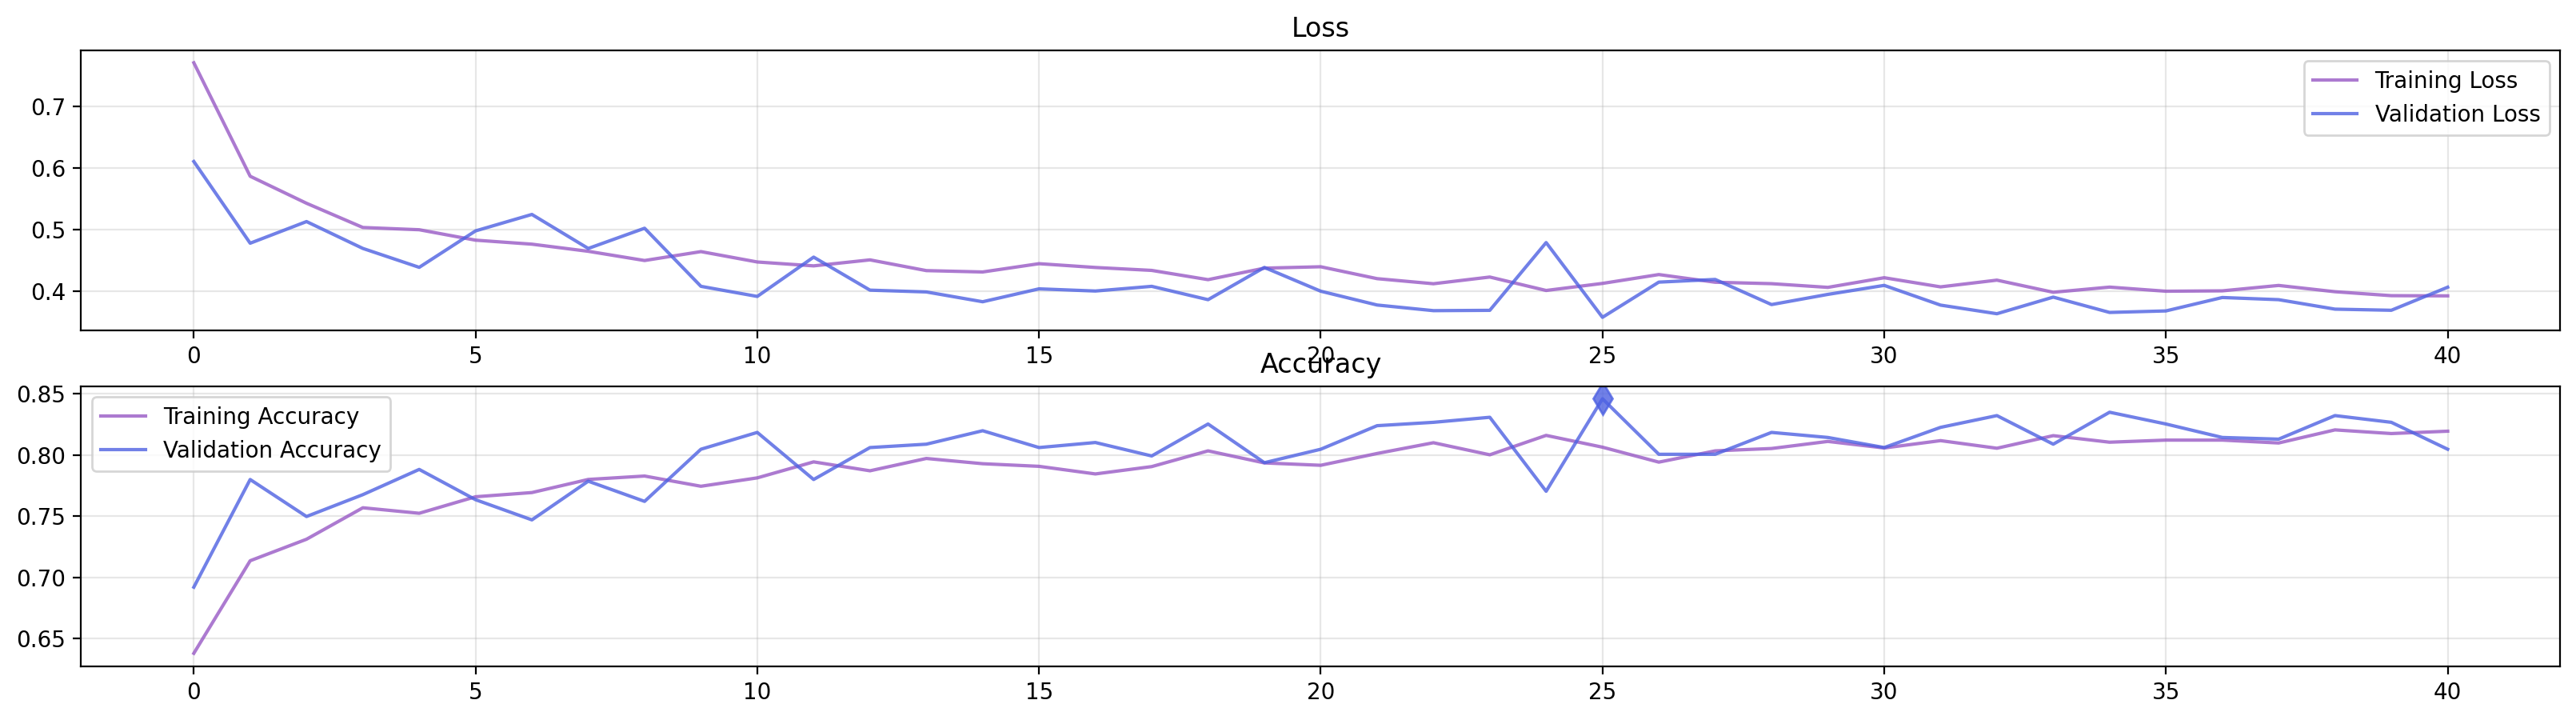

In [15]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

Accuracy:	 0.8391
Precision:	 0.8416
Recall:		 0.839
F1:		 0.8388


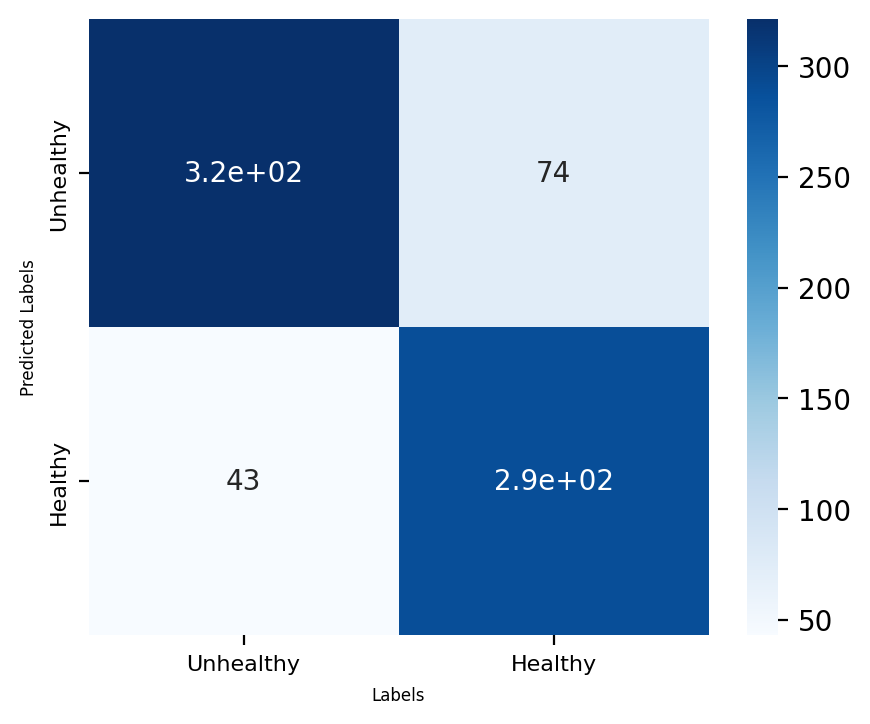

In [16]:
plot_confusion_matrix(model, XTE, YTE, (5,4), NAME_CMATRIX)

**Save the Model**

In [42]:
model.save(NAME_MODEL)

**Zip Model and Plots**

In [43]:
!zip -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png {NAME_CMATRIX}.png

  adding: ConvNeXtV2_t002/ (stored 0%)
  adding: ConvNeXtV2_t002/variables/ (stored 0%)
  adding: ConvNeXtV2_t002/variables/variables.index (deflated 77%)
  adding: ConvNeXtV2_t002/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtV2_t002/saved_model.pb (deflated 92%)
  adding: ConvNeXtV2_t002/fingerprint.pb (stored 0%)
  adding: ConvNeXtV2_t002/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtV2_t002/assets/ (stored 0%)
  adding: ConvNeXtV2_t002_plot.png (deflated 11%)
  adding: ConvNeXtV2_t002_cmatrix.png (deflated 16%)


**Delete the Model**

In [44]:
del model

# Tuning

**Load the Model**

In [45]:
ft_model = tfk.models.load_model(NAME_MODEL)

**Count the Layers**

In [ ]:
ft_model.get_layer('convnext_base').trainable = True
c = 0
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers):
   c += 1

print("Layers: ",c)
print()

Layers:  295



**Train only the Last Layers**

In [46]:
for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:200]):
  layer.trainable=False

ft_model.compile(
  loss=tfk.losses.CategoricalCrossentropy(),
  optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
  metrics=['accuracy']
)

**Train the Tuning Model**

In [48]:
BATCH = 128
EPOCHS = 300

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                                                       # Metric to monitor (validation mean squared error in this case)
    patience=5,                                                                   # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,                                                                  # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                                                   # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                                                   # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = ft_model.fit(
    x = XT,                                                                       # We need to apply the preprocessing thought for the MobileNetV2 network
    y = YT,
    batch_size = BATCH,
    epochs = EPOCHS,
    validation_data = (XV, YV),                                                   # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks
).history

Epoch 1/300
37/37 [==============================] - 38s 928ms/step - loss: 0.3969 - accuracy: 0.8139 - val_loss: 0.3361 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 2/300
37/37 [==============================] - 18s 492ms/step - loss: 0.3932 - accuracy: 0.8222 - val_loss: 0.3413 - val_accuracy: 0.8459 - lr: 0.0010
Epoch 3/300
37/37 [==============================] - 18s 493ms/step - loss: 0.3822 - accuracy: 0.8280 - val_loss: 0.3398 - val_accuracy: 0.8501 - lr: 0.0010
Epoch 4/300
37/37 [==============================] - 18s 496ms/step - loss: 0.3770 - accuracy: 0.8274 - val_loss: 0.3454 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 5/300
37/37 [==============================] - 18s 494ms/step - loss: 0.3870 - accuracy: 0.8241 - val_loss: 0.3483 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 6/300
37/37 [==============================] - 18s 489ms/step - loss: 0.3785 - accuracy: 0.8224 - val_loss: 0.3543 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 7/300
37/37 [==============================] - 18s 5

**Saving and Plotting**

In [49]:
FT_NAME = NAME_MODEL+"_Tuning"
FT_PLOT = NAME_PLOT+"_Tuning"
FT_CMATRIX = NAME_CMATRIX+"_Tuning"

**Test Prediction Accuracy**

In [50]:
tp = test_prediction(ft_model, XTE, YTE)

Accuracy Score over the Test Set: 0.8418



**Plot Loss**

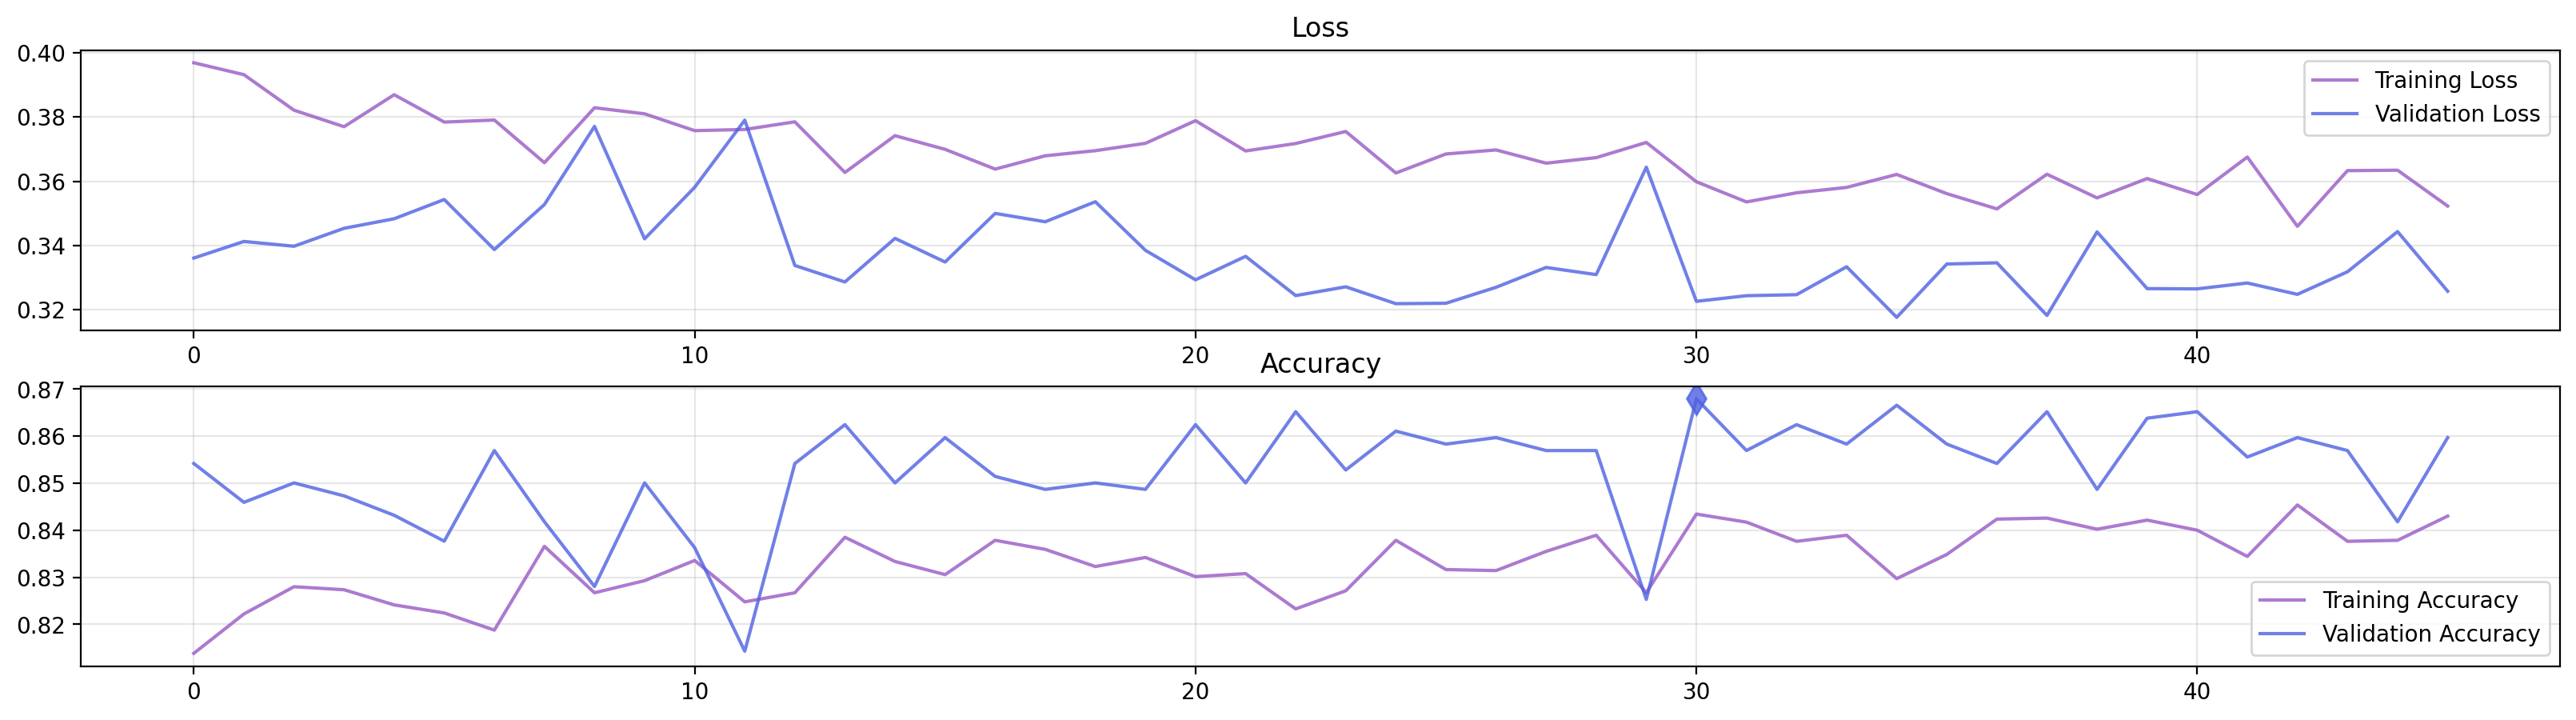

In [51]:
plot_losses(history, (20,5), FT_NAME)

**Plot Confusion Matrix**

Accuracy:	 0.8418
Precision:	 0.8432
Recall:		 0.8418
F1:		 0.8416


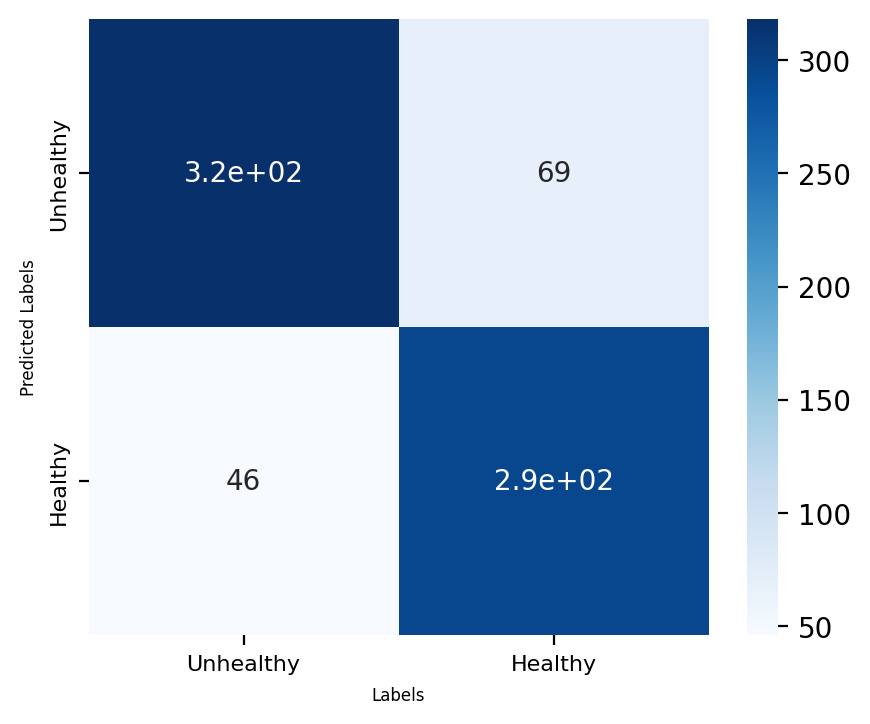

In [52]:
plot_confusion_matrix(ft_model, XTE, YTE, (5,4), NAME_CMATRIX)

**Save the Model**

In [ ]:
ft_model.save(NAME_MODEL+"_Tuning")

**Zip the Model and the Plots**

In [ ]:
!zip -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png {FT_CMATRIX}.png

	zip warning: name not matched: ConvNeXtV2_006_1_plot_Tuning.png
	zip warning: name not matched: ConvNeXtV2_006_1_cmatrix_Tuning.png
  adding: ConvNeXtV2_006_1_Tuning/ (stored 0%)
  adding: ConvNeXtV2_006_1_Tuning/variables/ (stored 0%)
  adding: ConvNeXtV2_006_1_Tuning/variables/variables.index (deflated 78%)
  adding: ConvNeXtV2_006_1_Tuning/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtV2_006_1_Tuning/saved_model.pb (deflated 92%)
  adding: ConvNeXtV2_006_1_Tuning/fingerprint.pb (stored 0%)
  adding: ConvNeXtV2_006_1_Tuning/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtV2_006_1_Tuning/assets/ (stored 0%)


**Plot Test Images wrongly Predicted**

In [ ]:
err = []
err_lbl = []
indices = []
for i, lbl in enumerate(tp):
  if lbl != np.argmax(YTE[i],axis=-1):
    err.append(XTE[i])
    err_lbl.append("unhealthy" if lbl else "healthy")
    indices.append(i)

In [ ]:
for i in range(6):
  plot_images(err[i*10:i*10+10], err_lbl[i*10:i*10+10], 0, 2, 5)

# Notes
We would like to thank the team of the 2023/2024 AN2DL course taught at Politecnico di Milano

More code available at this link: https://github.com/GioBar00/AN2DL_23-24_Apple_Elixir

Credits:
>*Andrea Alari*   https://github.com/andrea-alari

>*Giovanni Barbiero* https://github.com/GioBar00

>*Alexandro Sas*  https://github.com/AlexandroSas